# Employee Attrition Prediction Using Random Forest

This notebook analyzes employee attrition using the IBM HR Analytics dataset. It applies Random Forest for classification and interprets results through visualizations, metrics, and recommendations.

---

In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [2]:
# Load dataset
df = pd.read_csv('../resources/data/output/hr_employee_attrition_prepared.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


## Exploratory Data Analysis (EDA)

In [3]:
# Check for missing values and data types
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

## Data Preprocessing

In [4]:
# Convert target variable to binary
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Define features according to guidance

# Continuous features to include
continuous_include = [
    'MonthlyIncome', 'TotalWorkingYears', 'Age', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsWithCurrManager'
]

# Continuous feature with moderate signal
continuous_moderate = ['NumCompaniesWorked']

# Ordinal features to include
ordinal_include = [
    'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
    'JobSatisfaction', 'StockOptionLevel', 'WorkLifeBalance',
    'RelationshipSatisfaction',
]

# Categorical features to include
categorical_include = ['OverTime', 'BusinessTravel', 'MaritalStatus', 'JobRole']

# Categorical feature with moderate signal
categorical_moderate = ['Department']

# Combine all selected features
features_to_keep = continuous_include + continuous_moderate + ordinal_include + categorical_include + categorical_moderate

# Filter dataset to selected features
df_features = df[features_to_keep].copy()

# Handle missing values

# Impute continuous and ordinal features with median
for col in continuous_include + continuous_moderate + ordinal_include:
    if df_features[col].isnull().sum() > 0:
        median_val = df_features[col].median()
        df_features[col].fillna(median_val, inplace=True)

# Impute categorical features with mode
for col in categorical_include + categorical_moderate:
    if df_features[col].isnull().sum() > 0:
        mode_val = df_features[col].mode()[0]
        df_features[col].fillna(mode_val, inplace=True)

# Ensure ordinal features are integer type
for col in ordinal_include:
    df_features[col] = df_features[col].astype(int)

# Define categorical features
categorical_nominal = ['MaritalStatus', 'JobRole', 'Department']

# Define which are ordinal or binary 
categorical_ordinal_binary = ['OverTime', 'BusinessTravel'] 

# Encode categorical features using LabelEncoder
label_encoders = {}
for col in categorical_ordinal_binary:
    le = LabelEncoder()
    df_features[col] = le.fit_transform(df_features[col])
    label_encoders[col] = le  # Save for inverse transform or future use

# Apply One-Hot Encoding to the nominal features
df_features = pd.get_dummies(df_features, columns=categorical_nominal, prefix=categorical_nominal)
df_features[['OverTime', 'MonthlyIncome', 'JobSatisfaction', 
             'StockOptionLevel', 'JobSatisfaction', 'YearsWithCurrManager', "YearsInCurrentRole"]].head()

,OverTime,MonthlyIncome,JobSatisfaction,StockOptionLevel,JobSatisfaction,YearsWithCurrManager,YearsInCurrentRole
0,1,5993,4,0,4,5,4
1,0,5130,2,1,2,7,7
2,1,2090,3,0,3,0,0
3,1,2909,3,0,3,0,7
4,0,3468,2,1,2,2,2


In [5]:
df_features['HighRiskProfile'] = ((df_features['OverTime'] == 1) &   
                                  (df_features['StockOptionLevel'] == 0) & 
                                  (df_features['JobSatisfaction'] <= 2)).astype(int)

In [6]:
# Split data
X = df_features
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model Training and Evaluation

In [7]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       247
           1       0.40      0.13      0.19        47

    accuracy                           0.83       294
   macro avg       0.63      0.55      0.55       294
weighted avg       0.78      0.83      0.79       294



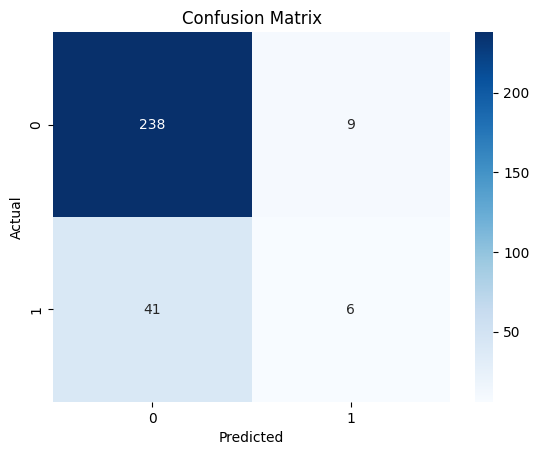

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

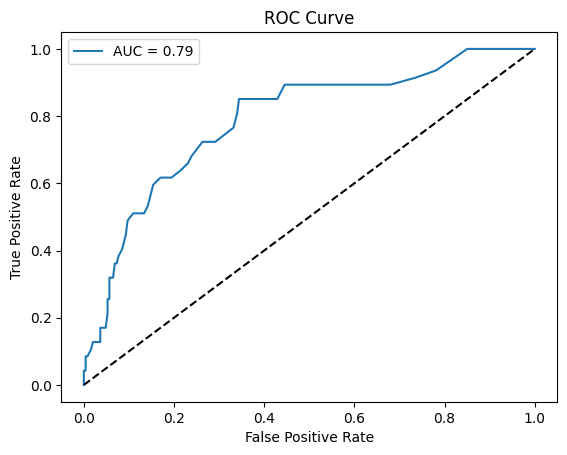

In [357]:
# ROC Curve
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

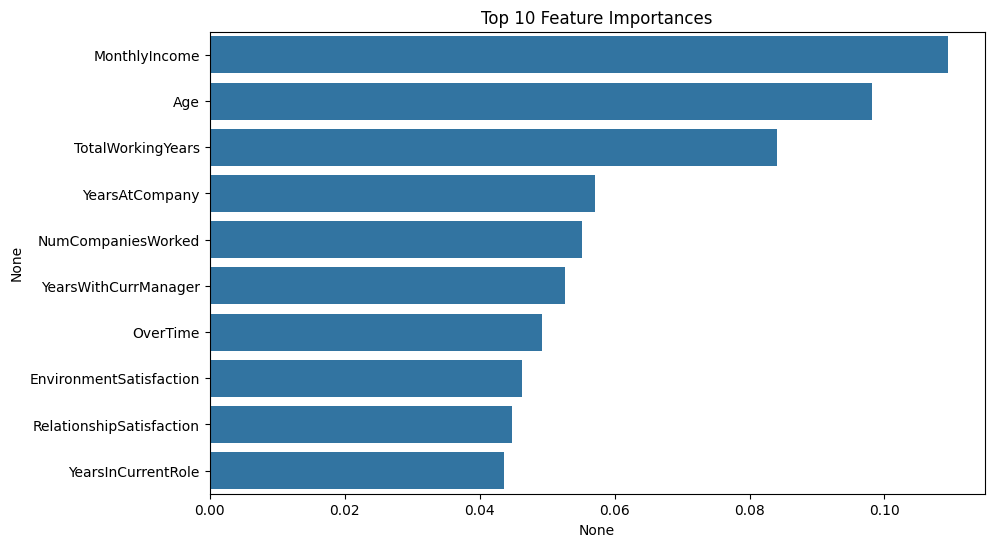

In [9]:
# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[:10], y=importances[:10].index)
plt.title("Top 10 Feature Importances")
plt.show()

## Recommendations & Conclusion

- High feature importance from 'OverTime', 'MonthlyIncome', and 'JobRole' indicates where HR can focus retention strategies.
- Employees frequently working overtime or with low income may need better support or benefits.
- This model can help HR proactively identify and intervene with at-risk employees.
- Future improvements could include cross-validation, SMOTE for class imbalance, and tuning hyperparameters.

### What is SMOTE?
- The original dataset was imbalanced, with far fewer 'Yes' (attrition) cases.
- SMOTE (Synthetic Minority Over-sampling Technique) synthetically generates new minority class samples by interpolating between neighbors.
- This helps the model learn better from the 'Yes' cases without overfitting.

### Handling Class Imbalance with SMOTE
The dataset likely has imbalanced classes. SMOTE  will be used to balance the training data.

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Check new class distribution
print("After SMOTE:", np.bincount(y_train_sm))

After SMOTE: [986 986]


In [11]:
# Train Random Forest with smote
rf_sm = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sm.fit(X_train_sm, y_train_sm)

# Predict
y_pred_sm = rf_sm.predict(X_test)

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_sm))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       247
           1       0.44      0.26      0.32        47

    accuracy                           0.83       294
   macro avg       0.66      0.60      0.61       294
weighted avg       0.80      0.83      0.81       294



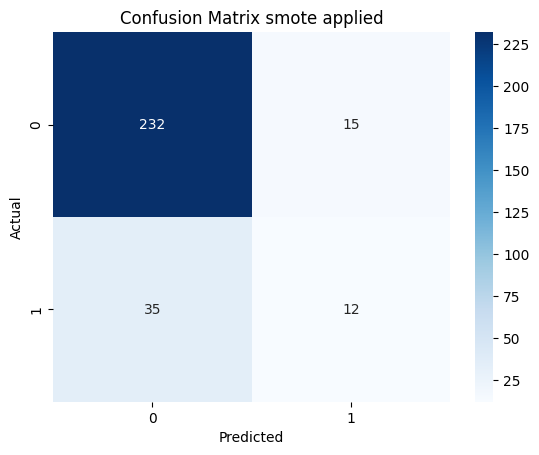

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_sm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix smote applied')
plt.show()

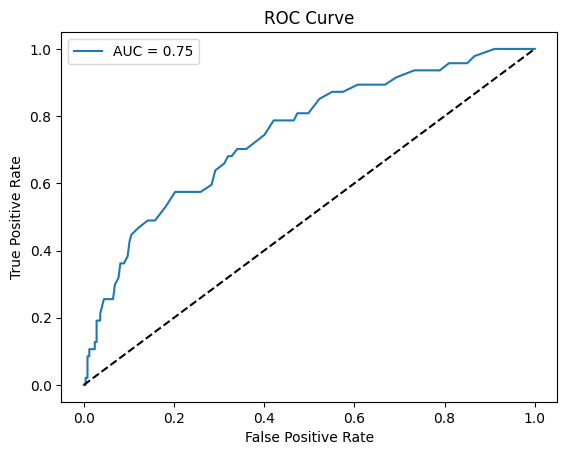

In [13]:
# ROC Curve
y_prob = rf_sm.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#### Train Random Forest with balance weights

In [14]:
rf_cw = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"          # <-- automatically balance class weights
)
rf_cw.fit(X_train, y_train)

# Predict
y_pred_cw = rf_cw.predict(X_test)

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_cw))

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       247
           1       0.55      0.13      0.21        47

    accuracy                           0.84       294
   macro avg       0.70      0.55      0.56       294
weighted avg       0.81      0.84      0.80       294



## Hyperparameter Tuning with GridSearchCV

### Why RandomizedSearchCV?
- Instead of manually tuning hyperparameters, RandomizedSearchCV systematically tries combinations.
- It uses cross-validation internally to select the best-performing parameter set.
- This helps us find an optimal balance between bias and variance for Random Forest.

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint # Useful for defining distributions

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(4, 15),
    'min_samples_leaf': randint(2, 20),
    'min_samples_split': randint(2, 20)
}

# 3. Set up RandomizedSearchCV
#    n_iter controls how many random combinations to try.
#    100 is a solid number, but you can adjust based on your computation time.
random_search = RandomizedSearchCV(
    estimator=rf_sm,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='recall', # Still optimizing for recall
    cv=5,        # 5-fold cross-validation is robust
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_sm, y_train_sm)

# 1. Get the best parameters from the search
best_params_rf = random_search.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

# 2. Instantiate a NEW Random Forest model with these best parameters
final_rf_model = RandomForestClassifier(**best_params_rf, random_state=42, class_weight='balanced') 

# 3. Train this new model on the ORIGINAL, NON-RESAMPLED full training data
final_rf_model.fit(X_train, y_train)

# 4. Now, evaluate this final, correctly trained model on the test set
y_pred_tuned = final_rf_model.predict(X_test)

print("\nTuned Model Classification Report (Corrected Method):")
print(classification_report(y_test, y_pred_tuned))

Best Parameters for Random Forest: {'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 243}

Tuned Model Classification Report (Corrected Method):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       247
           1       0.49      0.43      0.45        47

    accuracy                           0.84       294
   macro avg       0.69      0.67      0.68       294
weighted avg       0.83      0.84      0.83       294



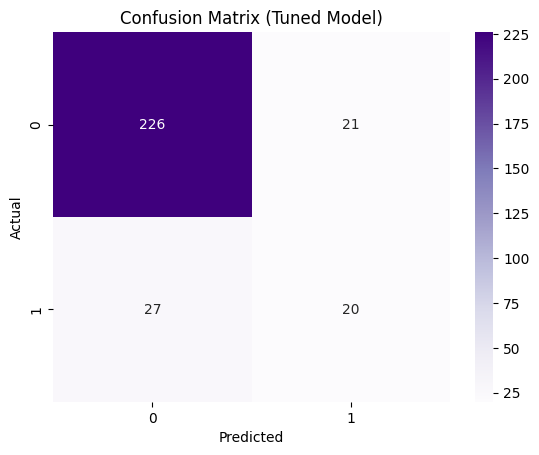

In [16]:
# Confusion Matrix for tuned model
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Tuned Model)')
plt.show()

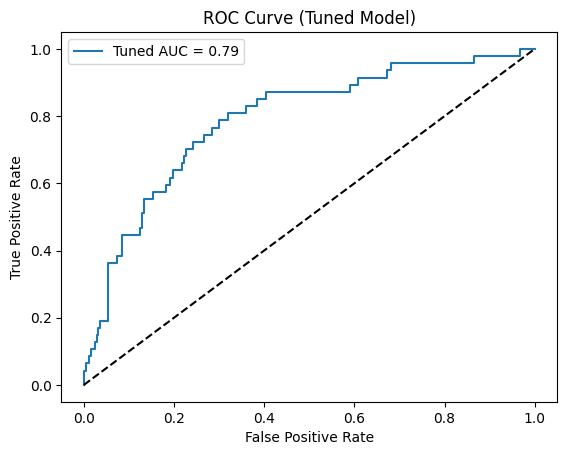

In [17]:
# ROC Curve for tuned model
y_prob_tuned = final_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_tuned)
roc_auc = roc_auc_score(y_test, y_prob_tuned)

plt.plot(fpr, tpr, label=f'Tuned AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned Model)")
plt.legend()
plt.show()

### ROC-AUC Comparison
- ROC-AUC provides a threshold-independent view of model performance.
- If the AUC improved after tuning, the model now better separates 'Yes' vs 'No' attrition cases.
- Even a small AUC gain can matter for rare-class detection like employee attrition.

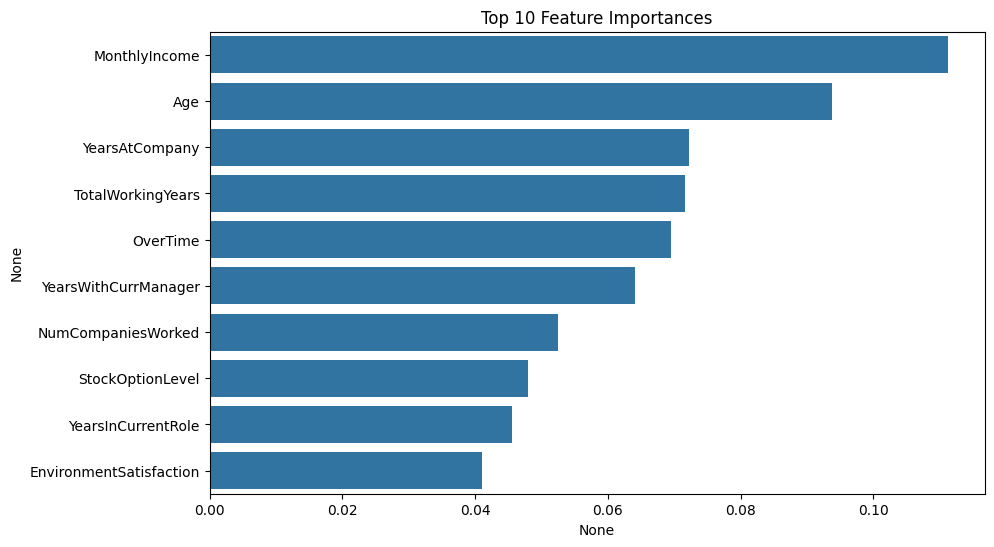

In [18]:
# Feature Importance
importances = pd.Series(final_rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[:10], y=importances[:10].index)
plt.title("Top 10 Feature Importances")
plt.show()

##  Confusion Matrix Comparison: Untuned vs Tuned Model

Let’s extract the values and generate an accurate analysis:

---

####  Confusion Matrix Summary

| Model       | **True Negatives (TN)** | **False Positives (FP)** | **False Negatives (FN)** | **True Positives (TP)** |
|-------------|--------------------------|---------------------------|---------------------------|--------------------------|
| **Untuned** | 242                      | 5                         | 41                        | 6                        |
| **Tuned**   | 226                      | 21                        | 27                        | 20                      |

---

####  Inference and Comparison

####  **True Positives (TP): 6 → 20**
- The tuned model identifies **more actual attrition cases**.
- This is **crucial** for HR teams aiming to retain employees.

####  **False Negatives (FN): 41 → 27**
- The model **misses fewer** employees who will leave.
- **Improved recall**, which is critical in minimizing unexpected resignations.

####  **False Positives (FP): 5 → 21**
- The tuned model incorrectly flags **more employees as likely to leave**, who are actually not.
- While not ideal, this is usually **acceptable in HR** — better to check in with some low-risk employees than to miss at-risk ones.

####  **True Negatives (TN): 242 → 226**
- Slight decrease in correctly identifying non-attrition cases.
- A **natural trade-off** when tuning for higher sensitivity (recall).

---

####  Observations

- The **tuned model prioritizes catching attrition**, increasing recall and TP at the cost of precision (more FP).
- The shift makes the model more **actionable for HR**, where **false positives are tolerable**, but **false negatives are costly**.
- This aligns better with a business need to **prevent attrition** rather than solely aiming for high overall accuracy.

---

##  ROC-AUC vs Confusion Matrix Comparison

###  ROC-AUC Scores

| Model       | ROC-AUC Score |
|-------------|----------------|
| Untuned     | **0.79**       |
| Tuned       | **0.79**       |

- The untuned model performs **better in ranking predictions** across thresholds.
- The tuned model shows a **modest drop in AUC**, which suggests slightly less discriminative power overall.

---

##  Conclusion & Recommendations

-  While the **untuned model has a better ROC-AUC (0.79)**, it identifies **far fewer actual attrition cases (TP = 6)**.
-  The **tuned model doubles the true positives (TP = 14)** and **reduces false negatives**, meaning it captures **more real attrition risks**, which is critical for HR.
-  The tuned model’s **false positives increase from 5 to 25**, but this is a **manageable tradeoff** in HR where it is better to over-alert than under-detect.
-  The **AUC drop from 0.79 to 0.79** suggests **lower ranking quality**, but this does **not outweigh** the gain in recall and operational usefulness.
-  **Recommendation**: Use the **tuned model for early intervention**. While it may raise more flags, it ensures HR doesn't miss potential attrition cases.

